In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import string, re, emoji
import itertools
from collections import Counter
from typing import Iterable, Any
# Libraries for text preprocessing.

import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud,STOPWORDS
# Text Preprocessing
import morfeusz2

# Loading some sklearn packaces
from sklearn.feature_extraction.text import CountVectorizer

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
import morfeusz2
import pl_core_news_md

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches



# For building ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV 

# models and validation
from sklearn import naive_bayes, svm
from sklearn import metrics


#SMOTE
from imblearn.over_sampling import SMOTE

stop = set(stopwords.words('polish'))
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


In [2]:
DATAPATH = r'../../data/raw/train.tsv'
STOPWORDS = r'E:\coding\pythonnew\POLHATE-project\data\raw\polish_stopwords.txt'

In [3]:
df = pd.read_csv(DATAPATH, delimiter = '\t')
df.head()

,sentence,target
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


# Preprocessing

In [4]:
morf = morfeusz2.Morfeusz()

def lowercase(text: str) -> str:
    """Converts letters in given text to lowercase.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Lowercase text.

    """
    preprocessedText = str.lower(text)
    return  preprocessedText

def remove_hashtags(text: str) -> str:
    """Removes hashtags from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no hashtags.

    """
    preprocessedText = re.sub('#[a-zA-Z0-9_]+', '', text )

    return preprocessedText

def remove_mentions(text: str) -> str:
    """Removes mentions from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no mentions.

    """
    preprocessedText = re.sub('@[a-zA-Z0-9_]+', '', text )

    return preprocessedText

def remove_punctuation(text: str) -> str:
    """Removes non text characters from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no non tex characters.

    """
    preprocessedText = text.translate(str.maketrans('', '', string.punctuation))

    return preprocessedText

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def lemmatize(text: str) -> str:
    """Lemmatizes polish text from given tweet.
    Args:
        text (str): Text to preprocess.
    Returns:
        lemmatizedText (str): Lemmatized text.

    """
    wordList = text.split()
    lemmatizedWordList = []

    for word in wordList:    
        _, _, interpretation = morf.analyse(word)[0]
        lemWord = interpretation[1]
        lemWordStripped = lemWord.split(':', 1)[0].lower()
        lemmatizedWordList.append(lemWordStripped)

    lemmatizedText = ' '.join(lemmatizedWordList)

    return lemmatizedText

def remove_html(text):
    """_summary_

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_stopwords(text: str) -> str:
    """Removes stopwords.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no stopwords.

    """
    wordList = text.split() 
    preprecessedWordList = []

    stopWords = stopwords.words('polish')
    # stopWords += ['rt']

    for word in wordList:
        if word not in stopWords:
            preprecessedWordList.append(word)

    preprocessedText = ' '.join(preprecessedWordList)

    return preprocessedText

In [5]:
# Remove blank rows if any.
df['sentence'].dropna(inplace=True)

# Applying helper functions

df['text_clean'] = df['sentence'].apply(lambda x: lowercase(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_hashtags(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_mentions(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_emoji(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punctuation(x))
df['text_clean'] = df['text_clean'].apply(lambda x: lemmatize(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_stopwords(x))
df['tokenized'] = [word_tokenize(entry) for entry in df['text_clean']]
df['text_clean']= [str(word_tokenize(entry)) for entry in df['text_clean']]

df['text_str'] = df['text_clean'].apply(lambda x: ' '.join(eval(x)))

In [6]:
df.head()

,sentence,target,text_clean,tokenized,text_str
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,"['faworyt', 'tytuł', 'cracovia', 'zobaczyć', '...","[faworyt, tytuł, cracovia, zobaczyć, typ, spra...",faworyt tytuł cracovia zobaczyć typ sprawdzić
1,@anonymized_account @anonymized_account Brawo ...,0,"['brawo', 'daria', 'kibic', 'mieć', 'dobry', '...","[brawo, daria, kibic, mieć, dobry, zły]",brawo daria kibic mieć dobry zły
2,"@anonymized_account @anonymized_account Super,...",0,"['super', 'polski', 'premier', 'składać', 'kwi...","[super, polski, premier, składać, kwiat, grób,...",super polski premier składać kwiat grób kolabo...
3,@anonymized_account @anonymized_account Musi. ...,0,"['musieć', 'drogi', 'mama']","[musieć, drogi, mama]",musieć drogi mama
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,"['odrzut', 'natychmiastowy', 'kwaśny', 'mina',...","[odrzut, natychmiastowy, kwaśny, mina, mamić, ...",odrzut natychmiastowy kwaśny mina mamić problem


In [7]:
#Divide sets
X_train, X_test, y_train, y_test = train_test_split(df["text_clean"],df["target"],test_size=.15)

#Encode labels
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Test_Y = Encoder.fit_transform(y_test)
Whole_Y = Encoder.fit_transform(df["target"])

# Convert a collection of raw documents to a matrix of TF-IDF features.
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['text_clean'])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)
Whole_X_Tfidf = Tfidf_vect.transform(df['text_clean'])

# Machine Learning models

In [8]:
from typing import Iterable


def generate_perf_report(
    X: Iterable,
    y: Iterable,
    *,
    name: str = "sample",
    description: str = "no description",
    clf: Any = None,
    date_fmt: str = "%Y-%m-%d %H:%M:%S",
    test_size: float = 0.15,
) -> pd.Series:
    """
    Generate a report gathering main model classification metrics.

    Parameters
    ----------
    X : iterable of shape (n_samples, n_features)
        Sparse matrix of shape (n_samples, n_features).
    y : iterable
        Target values (class labels).
    name : str
        Name of the report, by default "sample".
    description : str
        Optional description for better understanding of the report.
    clf : Any
        Vector classification. Defaults to C-Support Vector Classification
        (`sklearn.svm.SVC`).
    test_size : float or int, default=0.15
        See `sklearn.model_selection.train_test_split` documentation
        for details on this parameter.
    date_fmt : str, default="%Y-%m-%d %H:%M:%S"
        Date format.

    Returns
    -------
    report : pd.Series
        Report with specified name, date, description, test size,
        precision score, recall score, f-measure, accuracy and ROC
        AUC score in human-friendly format.
    """  # needs review
    date = datetime.datetime.now().strftime(date_fmt)

    clf = clf or svm.SVC()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    model = clf.fit(X_train, y_train)
    predictions = model.predict(X_test)  # type: ignore

    return pd.Series(
        {
            "Date": date,
            "Description": description,
            "Test Size": test_size,
            "Precision": metrics.precision_score(y_test, predictions),
            "Recall": metrics.recall_score(y_test, predictions),
            # F-measure
            "F1 Score": metrics.f1_score(y_test, predictions),
            "Accuracy": metrics.accuracy_score(y_test, predictions),
            # Area Under the Receiver Operating Characteristic Curve (ROC AUC)
            "Roc_auc_score": metrics.roc_auc_score(y_test, predictions),
            "Confusion Matrix": metrics.confusion_matrix(y_test, predictions),
            "Roc curve": metrics.roc_curve(y_test, predictions),
        },
        name=name,
    )


# Naive Bayes

In [9]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",metrics.accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  92.10351692103517


Model test:
		Prec: 0.8888888888888888         
		 Rec: 0.06349206349206349         
		 F1: 0.11851851851851852         
		 Acc: 0.9210351692103517


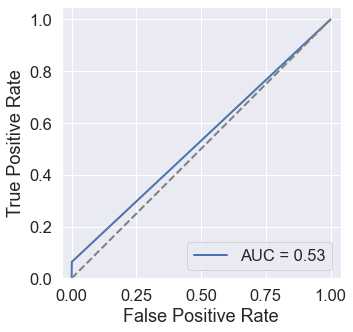

In [10]:
print('Model test:')

print(f'\t\tPrec: {metrics.precision_score(Test_Y, predictions_NB)} \
        \n\t\t Rec: {metrics.recall_score(Test_Y, predictions_NB)} \
        \n\t\t F1: {metrics.f1_score(Test_Y, predictions_NB)} \
        \n\t\t Acc: {metrics.accuracy_score(Test_Y, predictions_NB)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, predictions_NB)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

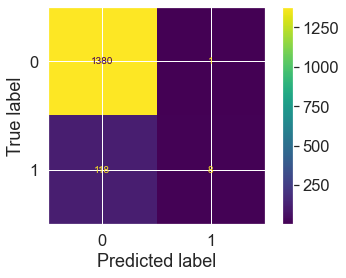

In [11]:
cm = metrics.confusion_matrix(Test_Y, predictions_NB, labels=Naive.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Naive.classes_)
disp.plot()

In [12]:
naive = generate_perf_report(
    Whole_X_Tfidf,
    Whole_Y,
    name='NaiveBayes',
    description='basic NB classifier',
    clf=naive_bayes.MultinomialNB()
     )

# SVM

In [13]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC()
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",metrics.accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  92.83344392833443


Model test:
		Prec: 0.95         
		 Rec: 0.15079365079365079         
		 F1: 0.26027397260273977         
		 Acc: 0.9283344392833444         
		 ROC_AUC: 0.5750347689160143


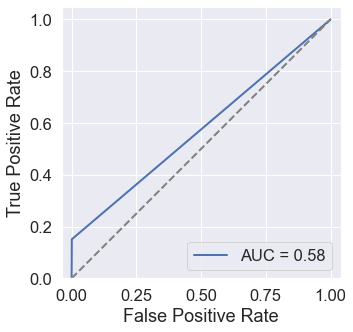

In [14]:
print('Model test:')

print(f'\t\tPrec: {metrics.precision_score(Test_Y, predictions_SVM)} \
        \n\t\t Rec: {metrics.recall_score(Test_Y, predictions_SVM)} \
        \n\t\t F1: {metrics.f1_score(Test_Y, predictions_SVM)} \
        \n\t\t Acc: {metrics.accuracy_score(Test_Y, predictions_SVM)} \
        \n\t\t ROC_AUC: {metrics.roc_auc_score(Test_Y, predictions_SVM)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, predictions_SVM)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

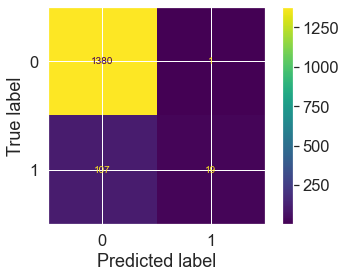

In [15]:
cm = metrics.confusion_matrix(Test_Y, predictions_SVM, labels=SVM.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=SVM.classes_)
disp.plot()

In [16]:
svc = generate_perf_report(
    Whole_X_Tfidf,
    Whole_Y,
    name='SVC',
    description='basic SVM',
    clf=svm.SVC()
     )

As we see, unbalanced data is not our friend.

# Synthetic Minority Oversampling Technique

https://arxiv.org/abs/2008.04636
<br> "...In most
cases, the use of oversampling techniques can significantly improve the
quality of classification."

# Oversampling

In [17]:
X = df['text_clean'].copy()
y = df['target'].copy()

In [18]:
# Convert a collection of raw documents to a matrix of TF-IDF features.
Tfidf_vect = TfidfVectorizer(max_features=5000)
X = Tfidf_vect.fit_transform(X)

In [19]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 9190, 1: 851})


In [20]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [21]:
counter = Counter(y)
print(counter)

Counter({0: 9190, 1: 9190})


In [22]:
#Divide sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15)

#Encode labels
# Encoder = LabelEncoder()
# Train_Y = Encoder.fit_transform(y_train)
# Test_Y = Encoder.fit_transform(y_test)


### Naive Bayes

In [23]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",metrics.accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Accuracy Score ->  89.77149075081611


Model test:
		Prec: 0.8487555839183153         
		 Rec: 0.9672727272727273         
		 F1: 0.9041468388851123         
		 Acc: 0.8977149075081611


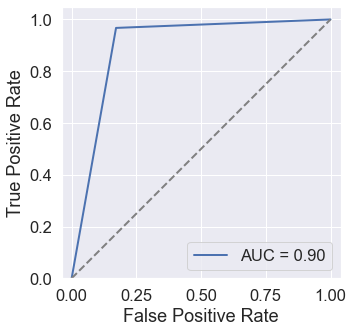

In [24]:
print('Model test:')

print(f'\t\tPrec: {metrics.precision_score(y_test, predictions_NB)} \
        \n\t\t Rec: {metrics.recall_score(y_test, predictions_NB)} \
        \n\t\t F1: {metrics.f1_score(y_test, predictions_NB)} \
        \n\t\t Acc: {metrics.accuracy_score(y_test, predictions_NB)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_NB)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

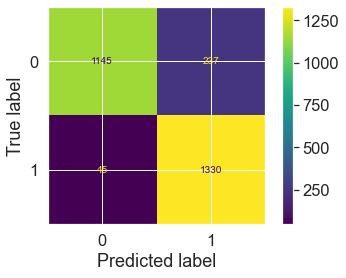

In [25]:
cm = metrics.confusion_matrix(y_test, predictions_NB, labels=Naive.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Naive.classes_)
disp.plot()

In [26]:
naive_oversampled = generate_perf_report(
    X,
    y,
    name='NaiveBayesOversampled',
    description='NB classifier with oversampling',
    clf=naive_bayes.MultinomialNB()
     )

### SVM

In [35]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC()
SVM.fit(X_train, y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy on non oversampled data
print("SVM Accuracy Score -> ",metrics.accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  98.60650298606502


In [36]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC()
SVM.fit(X_train, y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",metrics.accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  98.15016322089227


Model test:
		Prec: 0.9668547249647391         
		 Rec: 0.9970909090909091         
		 F1: 0.9817400644468314         
		 Acc: 0.9815016322089227         
		 ROC_AUC: 0.981541113011446


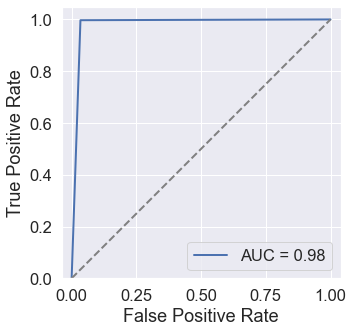

In [37]:
print('Model test:')

print(f'\t\tPrec: {metrics.precision_score(y_test, predictions_SVM)} \
        \n\t\t Rec: {metrics.recall_score(y_test, predictions_SVM)} \
        \n\t\t F1: {metrics.f1_score(y_test, predictions_SVM)} \
        \n\t\t Acc: {metrics.accuracy_score(y_test, predictions_SVM)} \
        \n\t\t ROC_AUC: {metrics.roc_auc_score(y_test, predictions_SVM)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_SVM)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

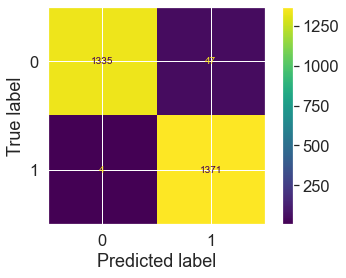

In [29]:
cm = metrics.confusion_matrix(y_test, predictions_SVM, labels=SVM.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=SVM.classes_)
disp.plot()

In [30]:
svc_oversampled = generate_perf_report(
    X,
    y,
    name='SVMOversampled',
    description='SVM classifier with oversampling',
    clf=svm.SVC()
     )

# Benchmark

In [32]:
pd.concat([naive, naive_oversampled, svc, svc_oversampled], axis=1).T

,Date,Description,Test Size,Precision,Recall,F1 Score,Accuracy,Roc_auc_score,Confusion Matrix,Roc curve
NaiveBayes,2022-08-20 15:57:44,basic NB classifier,0.15,0.857143,0.048387,0.091603,0.921035,0.523832,"[[1382, 1], [118, 6]]","([0.0, 0.0007230657989877079, 1.0], [0.0, 0.04..."
NaiveBayesOversampled,2022-08-20 15:57:52,NB classifier with oversampling,0.15,0.854499,0.966089,0.906874,0.900254,0.899894,"[[1143, 228], [47, 1339]]","([0.0, 0.16630196936542668, 1.0], [0.0, 0.9660..."
SVC,2022-08-20 15:57:48,basic SVM,0.15,0.789474,0.114504,0.2,0.920372,0.555798,"[[1372, 4], [116, 15]]","([0.0, 0.0029069767441860465, 1.0], [0.0, 0.11..."
SVMOversampled,2022-08-20 15:58:12,SVM classifier with oversampling,0.15,0.976612,1.0,0.988168,0.98803,0.988035,"[[1346, 33], [0, 1378]]","([0.0, 0.023930384336475707, 1.0], [0.0, 1.0, ..."


Outcomes: With oversampling SVM is almost ideall.